Now that we've figured out more or less how to go from model to mask file, it would be nice to be able to run the predictions on all the validation files.Therefore, lets' redo the validation folder images so that they are in neat slices ready for reassembling

#### Imports

In [95]:
from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *
import tifffile as tiff
from tqdm import tqdm
from skimage.external import tifffile as sktif
from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    "Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"
from importlib import reload

from skimage.segmentation import *
from scipy.ndimage.morphology import distance_transform_edt as SDT
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.io import imread_collection
from skimage.measure import regionprops, find_contours
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from skimage.morphology import extrema
import cv2
import re
from lovasz_losses import *
def accuracy_pixel(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()


In [4]:
data_dir = Path("/media/wwymak/Storage/urban-3D-satellite")
train_dir = data_dir / "training"
cropped_dir =  data_dir / "cropped_training"
cropped_val_dir =  data_dir / "cropped_validation"
train_cropped_imgs = [f.name for f in (data_dir / "cropped_training").ls() if f.name.endswith('RGB.tif')]
valid_cropped_imgs = [f.name for f in (data_dir / "cropped_validation").ls() if f.name.endswith('RGB.tif')]



In [5]:
img_ids = list(set([re.sub(r"_\d{1,2}_RGB.tif", "",fname ) for fname in valid_cropped_imgs]))

In [6]:
img_ids[:5]

['JAX_Tile_084',
 'TAM_Tile_119',
 'JAX_Tile_073',
 'TAM_Tile_037',
 'JAX_Tile_028']

Create a new folder to hold the ordered validation set

In [8]:
ordered_cropped_val_dir = data_dir / "ordered_cropped_validation"
ordered_cropped_val_dir.mkdir(exist_ok=True)

In [35]:
slice_indexes = list(range(0,2048-128, 128))
def parse_one_image(img_id, extension="RGB", dimensions=3):
    parent = sktif.imread(str(train_dir/f"{img_id}_{extension}.tif"))
    for i in slice_indexes:
        for j in slice_indexes:
            img_slice = parent[i:i+256, j:j+256, :] if dimensions ==3 else parent[i:i+256, j:j+256]
            sktif.imsave(str(ordered_cropped_val_dir/f"{img_id}_{extension}_{i}_{j}.tif"), img_slice)

In [31]:
%time out=[parse_one_image(id) for id in img_ids]

CPU times: user 1.41 s, sys: 730 ms, total: 2.14 s
Wall time: 3.64 s


In [37]:
%time out=[parse_one_image(id, extension="GTL", dimensions=1) for id in img_ids]
%time out=[parse_one_image(id, extension="GTI", dimensions=1) for id in img_ids]
%time out=[parse_one_image(id, extension="DSM", dimensions=1) for id in img_ids]

CPU times: user 1.13 s, sys: 408 ms, total: 1.54 s
Wall time: 2.27 s
CPU times: user 1.25 s, sys: 479 ms, total: 1.73 s
Wall time: 2.63 s
CPU times: user 1.3 s, sys: 805 ms, total: 2.1 s
Wall time: 8.85 s


#### Create testing learner to run on the validation images

In [16]:

codes = ["background", "building"]
src_test = (SegmentationItemList.from_folder(data_dir)
            .filter_by_func(lambda f: "RGB" in f.name)
            .split_by_folder(train="cropped_train", valid="ordered_cropped_validation")            
            .label_empty())

wd =1e-2
metrics = [accuracy_pixel,dice]

size = 256
bs=32
data_test = (src_test.transform(size=size)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
data_test.c = 2
learn = unet_learner(data_test, models.resnet34, metrics=metrics, wd=wd, loss_func=combined_loss2)
learn.load('/media/wwymak/Storage/urban-3D-satellite/models/lovaz-loss-stage4-ignore-none')
learn.to_fp16();

#### make predictions

In [18]:
learn.data.valid_dl.x.items[0:5]

array([PosixPath('/media/wwymak/Storage/urban-3D-satellite/ordered_cropped_validation/JAX_Tile_066_RGB_1152_1792.tif'),
       PosixPath('/media/wwymak/Storage/urban-3D-satellite/ordered_cropped_validation/TAM_Tile_041_RGB_896_256.tif'),
       PosixPath('/media/wwymak/Storage/urban-3D-satellite/ordered_cropped_validation/TAM_Tile_037_RGB_1152_1664.tif'),
       PosixPath('/media/wwymak/Storage/urban-3D-satellite/ordered_cropped_validation/TAM_Tile_041_RGB_896_1152.tif'),
       PosixPath('/media/wwymak/Storage/urban-3D-satellite/ordered_cropped_validation/JAX_Tile_066_RGB_1792_1536.tif')],
      dtype=object)

In [19]:
predictions = learn.get_preds(DatasetType.Valid)

In [79]:
filepaths = np.array([str(f) for f in learn.data.valid_dl.x.items])

predicted_masks = torch.argmax(predictions[0], dim=1)
predicted_masks.shape

torch.Size([6750, 256, 256])

In [91]:
slice_indexes = list(range(0,2048-128, 128))
def combine_one_image(img_id):
    img_fnames = []
    to_combine = []
    for i in slice_indexes:
        for j in slice_indexes:
            img_fnames.append(f"/media/wwymak/Storage/urban-3D-satellite/ordered_cropped_validation/{img_id}_RGB_{i}_{j}.tif")

    indexes = torch.LongTensor([np.argwhere(filepaths == fname)[0][0] for fname in img_fnames])
    predicted_patches = torch.index_select(predicted_masks, dim=0, index=indexes)
    
    for idx, fpath in enumerate(img_fnames):
        full_img = torch.zeros((2048, 2048))
        start_index_row, start_index_col = [int(x) for x in Path(fpath).name.replace('.tif','').split('_')[4:]]
        full_img[start_index_row:start_index_row+256, start_index_col: start_index_col+256] = predicted_patches[idx]
        to_combine.append(full_img)
        
    return torch.stack(to_combine).sum(0).numpy()

In [92]:
img_ids[0]
test_output = combine_one_image(img_ids[0])

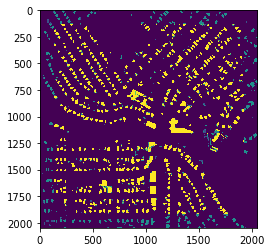

In [93]:
plt.imshow(test_output)

In [97]:
def label_save_output(prediction_mask, img_id):
    thresh = threshold_otsu(prediction_mask)
    bw = closing(prediction_mask > thresh, square(10))
    cleared = clear_border(bw)
    label_image = label(bw)
    sktif.imsave(f"/media/wwymak/Storage/urban-3D-satellite/{img_id}_prediction.tif", label_image)

In [98]:
for img_id in tqdm(img_ids):
    predicted_mask = combine_one_image(img_id)
    label_save_output(predicted_mask, img_id)

100%|██████████| 30/30 [01:17<00:00,  2.58s/it]
